# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [11]:
import pandas as pd
from palmerpenguins import load_penguins
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

#rename penguins dataset
penguins = load_penguins()
#drop NA
penguins = penguins.dropna()

#categorical dummify
cat_transform = Pipeline([
    ("dummy", OneHotEncoder())
])

penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [9]:
#numeric transformer (standardize)
num_transform = Pipeline([
    ("scalar", StandardScaler())
])

#column transformer (apply the dummification and standardization)
ct = ColumnTransformer([
    ('num', num_transform, make_column_selector(dtype_include=np.number)),
    ("cat", cat_transform, make_column_selector(dtype_include=object))
])

#predictors and response
X = penguins.drop(columns=['species'])
y = penguins['species']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#knn3 pipeline
pipeline_knn3 = Pipeline(
    [("preprocessor", ct),
     ("kNN", KNeighborsClassifier(n_neighbors=3))]
)

#knn100 pipeline
pipeline_knn100 = Pipeline(
    [("preprocessor", ct),
     ("kNN", KNeighborsClassifier(n_neighbors=100))]
)

#decision tree1 pipeline
pipeline_tree1 = Pipeline(
    [("preprocessor", ct),
     ("decision", DecisionTreeClassifier(ccp_alpha=1))]
)

#decision tree01 pipeline
pipeline_tree01 = Pipeline(
    [("preprocessor", ct),
     ("decision", DecisionTreeClassifier(ccp_alpha=0.1))]
)

In [10]:
#fit the models
pipeline_knn3.fit(X_train, y_train)
pipeline_knn100.fit(X_train, y_train)
pipeline_tree1.fit(X_train, y_train)
pipeline_tree01.fit(X_train, y_train)

#make predictions
pred_knn3 = pipeline_knn3.predict(X_test)
pred_knn100 = pipeline_knn100.predict(X_test)
pred_tree1 = pipeline_tree1.predict(X_test)
pred_tree01 = pipeline_tree01.predict(X_test)

#calculate probabilities
prob_knn3 = pipeline_knn3.predict_proba(X_test)
prob_knn100 = pipeline_knn100.predict_proba(X_test)
prob_tree1 = pipeline_tree1.predict_proba(X_test)
prob_tree01 = pipeline_tree01.predict_proba(X_test)

In [20]:
#create function for the metrics
def evaluate_model(y_true, y_pred, y_prob, classes):
    
    #initialize results
    results = {}

    #confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    results["confusion_matrix"] = cm

    #accuracy
    results["accuracy"] = accuracy_score(y_true, y_pred)

    #precision, recall, AUC, f1
    results["metrics"] = {}
    for i, cls in enumerate(classes):
        y_true_binary = (y_true == cls).astype(int)
        y_pred_binary = (y_pred == cls).astype(int)
        results["metrics"][cls] = {
            "precision": precision_score(y_true_binary, y_pred_binary, zero_division=0),
            "recall": recall_score(y_true_binary, y_pred_binary),
            "f1_score": f1_score(y_true_binary, y_pred_binary),
            "auc": roc_auc_score(y_true_binary, y_prob[:, i]) if y_prob is not None else None
        }
    
    return results

In [21]:
classes = y.unique().tolist()
#knn3 model
evaluate_model(y_test, pred_knn3, prob_knn3, classes)

{'confusion_matrix': array([[28,  0,  0],
        [ 0, 26,  0],
        [ 2,  0, 11]]),
 'accuracy': 0.9701492537313433,
 'metrics': {'Adelie': {'precision': 0.9333333333333333,
   'recall': 1.0,
   'f1_score': 0.9655172413793104,
   'auc': 1.0},
  'Gentoo': {'precision': 1.0,
   'recall': 1.0,
   'f1_score': 1.0,
   'auc': 0.3414634146341463},
  'Chinstrap': {'precision': 1.0,
   'recall': 0.8461538461538461,
   'f1_score': 0.9166666666666666,
   'auc': 0.2592592592592593}}}

In [22]:
#knn100 model
evaluate_model(y_test, pred_knn100, prob_knn100, classes)

{'confusion_matrix': array([[28,  0,  0],
        [ 0, 26,  0],
        [ 6,  0,  7]]),
 'accuracy': 0.9104477611940298,
 'metrics': {'Adelie': {'precision': 0.8235294117647058,
   'recall': 1.0,
   'f1_score': 0.9032258064516129,
   'auc': 0.972985347985348},
  'Gentoo': {'precision': 1.0,
   'recall': 1.0,
   'f1_score': 1.0,
   'auc': 0.039399624765478425},
  'Chinstrap': {'precision': 1.0,
   'recall': 0.5384615384615384,
   'f1_score': 0.7,
   'auc': 0.3383190883190883}}}

In [23]:
#decision tree1
evaluate_model(y_test, pred_tree1, prob_tree1, classes)

{'confusion_matrix': array([[28,  0,  0],
        [26,  0,  0],
        [13,  0,  0]]),
 'accuracy': 0.417910447761194,
 'metrics': {'Adelie': {'precision': 0.417910447761194,
   'recall': 1.0,
   'f1_score': 0.5894736842105263,
   'auc': 0.5},
  'Gentoo': {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'auc': 0.5},
  'Chinstrap': {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'auc': 0.5}}}

In [24]:
#decision tree01
evaluate_model(y_test, pred_tree01, prob_tree01, classes)

{'confusion_matrix': array([[24,  1,  3],
        [ 0, 25,  1],
        [ 3,  0, 10]]),
 'accuracy': 0.8805970149253731,
 'metrics': {'Adelie': {'precision': 0.8888888888888888,
   'recall': 0.8571428571428571,
   'f1_score': 0.8727272727272727,
   'auc': 0.9194139194139194},
  'Gentoo': {'precision': 0.9615384615384616,
   'recall': 0.9615384615384616,
   'f1_score': 0.9615384615384616,
   'auc': 0.6772983114446528},
  'Chinstrap': {'precision': 0.7142857142857143,
   'recall': 0.7692307692307693,
   'f1_score': 0.7407407407407407,
   'auc': 0.4216524216524216}}}

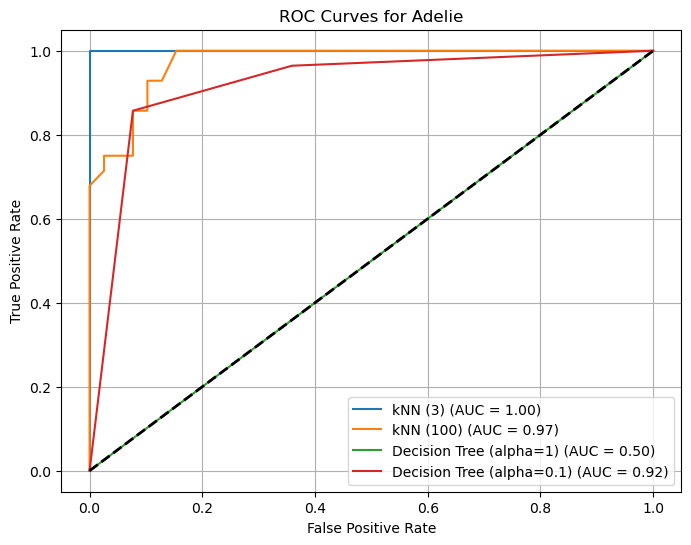

In [19]:
#ROC plot
def plot_roc_curves_all_models(y_true, probabilities, classes, species, model_names):
    """
    Plots the ROC curves for all models for the selected species.
    """
    plt.figure(figsize=(8, 6))
    species_idx = classes.index(species)

    for prob, model_name in zip(probabilities, model_names):
        #convert y to binary
        y_true_binary = (y_true == species).astype(int)
        #compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true_binary, prob[:, species_idx])
        roc_auc = auc(fpr, tpr)
        #plot
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    #reference line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.title(f"ROC Curves for {species}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

#store previous probabilities
probabilities = [prob_knn3, prob_knn100, prob_tree1, prob_tree01]
model_names = ["kNN (3)", "kNN (100)", "Decision Tree (alpha=1)", "Decision Tree (alpha=0.1)"]
#plot for adelie
plot_roc_curves_all_models(y_test, probabilities, classes, species="Adelie", model_names=model_names)
